In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '344277',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/utvlrrmevsn9Cb_Fs6kqlg__thumb/img/CjNBS17ZhTbUnnc2F7grdDBk4Us=/fit-in/200x150/filters:strip_icc()/pic6329299.jpg',
  'name': 'Corrosion',
  'yearpublished': '2021'},
 {'id': '237179',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/E8qBDKe39KEFMo-LhTNDQQ__thumb/img/jFQaWbcjoUzxS7p76LsGzg4piQk=/fit-in/200x150/filters:strip_icc()/pic6333980.jpg',
  'name': 'Weather Machine',
  'yearpublished': '2022'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 24)
page number = 20 (max: 100, len: 19)
page number = 30 (max: 100, len: 13)
page number = 40 (max: 100, len: 10)
page number = 50 (max: 100, len: 6)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 100, len: 1)
comments_df shape: (100301, 4)


,id,username,rating,value
0,344277,androgeus,N/A,soll im Oktober 21 bei Pegasus in Deutsch ersc...
1,344277,feldfan2014,N/A,[url=capstone-games.com]Capstone[/url] Deluxe ...
2,344277,icred,N/A,Pre-ordered from Capstone August 2021
3,344277,marstiller,N/A,December 21
4,344277,RufusMcDogg,N/A,Capstone
...,...,...,...,...
100296,167791,z_zadar,9,Some games are so much fun. Others can be a li...
100297,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
100298,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
100299,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 16240 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         16003
9          15636
8          13481
7           7483
N/A         6720
           ...  
6.6625         1
8.43312        1
6.34           1
5.67           1
7.022          1
Name: rating, Length: 541, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(77341, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6720, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'well balanced, want to play everyday.'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"A lot of actions available (too many?), and a useless conversion game to place tetris pieces. I won't play it again. There are much better worker placement games. (played a couple times and with the Norwegian expansion)"

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
38/38 - 4s - loss: 0.5863 - accuracy: 0.7592 - val_loss: 0.5220 - val_accuracy: 0.8404
Epoch 2/100
38/38 - 2s - loss: 0.4836 - accuracy: 0.8422 - val_loss: 0.4420 - val_accuracy: 0.8493
Epoch 3/100
38/38 - 2s - loss: 0.3983 - accuracy: 0.8545 - val_loss: 0.3770 - val_accuracy: 0.8607
Epoch 4/100
38/38 - 2s - loss: 0.3343 - accuracy: 0.8728 - val_loss: 0.3433 - val_accuracy: 0.8677
Epoch 5/100
38/38 - 2s - loss: 0.2909 - accuracy: 0.8882 - val_loss: 0.3285 - val_accuracy: 0.8736
Epoch 6/100
38/38 - 2s - loss: 0.2583 - accuracy: 0.9006 - val_loss: 0.3241 - val_accuracy: 0.8738
Epoch 7/100
38/38 - 2s - loss: 0.2320 - accuracy: 0.9117 - val_loss: 0.3261 - val_accuracy: 0.8726
Epoch 8/100
38/38 - 2s - loss: 0.2096 - accuracy: 0.9207 - val_loss: 0.3336 - val_accuracy: 0.8706
Epoch 9/100
38/38 - 2s - loss: 0.1903 - accuracy: 0.9295 - val_loss: 0.3452 - val_accuracy: 0.8669
Epoch 10/100
38/38 - 2s - loss: 0.1731 - accuracy: 0.9362 - val_loss: 0.3589 - val_accuracy: 0.8668
26/26 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000199077C2D30>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

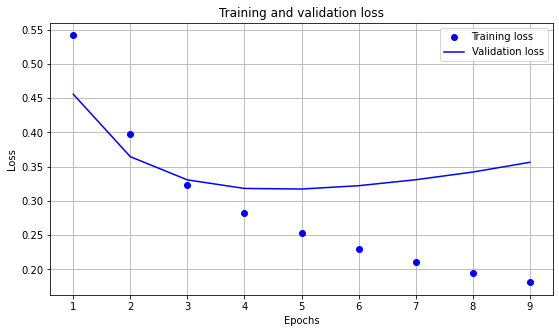

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

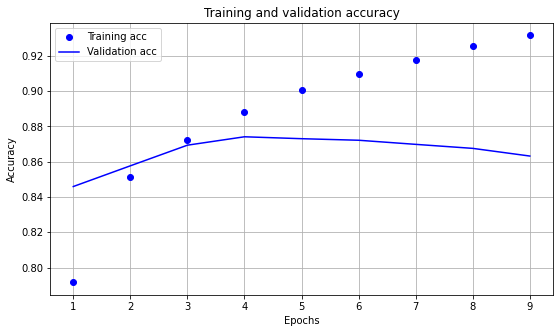

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"well balanced, want to play everyday."
score: 1.000000
actual: 1

input:
"edit: Feb 2020 - The longer I have this and the more I compare it with other area control games the more I enjoy and admire it's simplicity, focus and sharp design. Plays quickly, and is an easy teach with great depth."
score: 1.000000
actual: 1

input:
"I bought this game after one single try. Awesome under every aspect. The mechanics are many, but the scheme is quite easy to master. The cubes system to count the different resources are so ingenious you end up saying "how didn'tI think about this before???". The game itself is challenging, but meanwhile offers continuously different ways to make points and be somehow able to win in almost any condition. Finally, the flavour is THE BEST EVER. There is not one single card that doesn't feel right. The guys here know what's up. Everybody buy it now."
score: 1.000000
actual: 1

input:
"A lot of actions available (too many?), and a useless conversion game to p

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"Sleeved + I have upgraded my game with:   The Broken Token's Game Organiser  Fan made Image that goes in between the player trays to add that additional flavour and colour. Acrylic Resource cubes: science, floaters, microbes, animals etc Metal copper, silver and gold goblets to replace the stock plastic component money"
score: 1.000000

input:
"I'm really interested in Spirit Island for being an anticolonialist, cooperative game with variable player powers."
score: 1.000000

input:
"Hesitantly curious.  I don't want to enter into a heavyweight legacy game lightly, but I do like the prospect of developing a fictional history together over the course of several plays"
score: 1.000000

input:
"*Blinged Out with Metal Coins, Realistic Resources, Campfire Encounter Tokens, and MeepleSource upgrades"
score: 0.000000

input:
"Early impression: umm yeah, not bad. Why is it this popular though? Am I not getting it?"
score: 0.000000

input:
"Olen kuulnud, et vähevõitu kordusmäng

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000019BEB349AC0>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.54


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.04


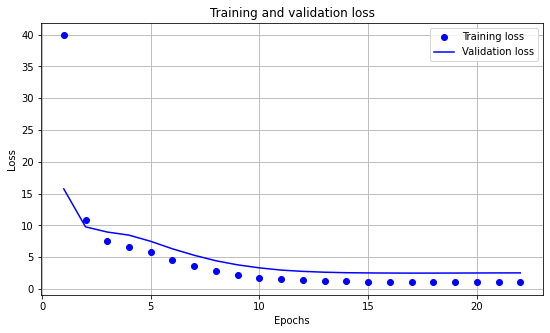

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

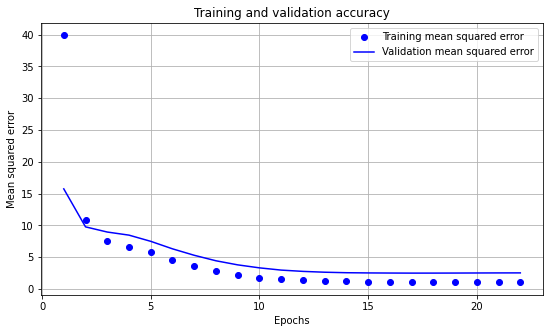

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"well balanced, want to play everyday."
score: 8.66
actual: 10.00 

input: 
"edit: Feb 2020 - The longer I have this and the more I compare it with other area control games the more I enjoy and admire it's simplicity, focus and sharp design. Plays quickly, and is an easy teach with great depth."
score: 8.22
actual: 8.00 

input: 
"I bought this game after one single try. Awesome under every aspect. The mechanics are many, but the scheme is quite easy to master. The cubes system to count the different resources are so ingenious you end up saying "how didn'tI think about this before???". The game itself is challenging, but meanwhile offers continuously different ways to make points and be somehow able to win in almost any condition. Finally, the flavour is THE BEST EVER. There is not one single card that doesn't feel right. The guys here know what's up. Everybody buy it now."
score: 9.63
actual: 10.00 

input: 
"A lot of actions available (too many?), and a useless conversion gam

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"+KS Upgrade Kit +Resin Clearing Markers +The Exiles and Partisans Deck +The Vagabond Pack"
    reg score: 8.22
    clf score: 1

"February 21, 2020 at 09:51am Order #209001 Board Game Bliss"
    reg score: 8.29
    clf score: 1

"Includes: Thor, Captain America, Ms. Marvel, Green Goblin scenario and Wrecking Crew scenario."
    reg score: 8.73
    clf score: 1

"I like the unique dark fantasy setting, leveling aspect, and the card combat. After 7 plays, I still have interest to continue but I'm hoping for some more variety or surprises.  I'm glad I started with this version because I think I'll definitely have had my fill after 20+ scenarios."
    reg score: 8.64
    clf score: 1

"includes Captain America, Ms. Marvel, and Green Goblin sets."
    reg score: 8.08
    clf score: 1

"Kickstarted deluxe edition.  Delivery in spring of 2022."
    reg score: 8.34
    clf score: 1

"2 - 5 players (best 3), 45 - 75 min, Age: 14+  Mariposas is a game of movement and set collection that lets pl

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.37 |           3699 |
| 167355 |          8.41 |           1999 |
| 167791 |          8.20 |           8516 |
| 169786 |          8.09 |           7519 |
| 170216 |          7.97 |           4365 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.06 |            325 |
| 167355 |          8.10 |            213 |
| 167791 |          8.19 |            453 |
| 169786 |          8.05 |            610 |
| 170216 |          8.05 |            329 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/utvlrrm...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,8.490673,NaN,1,2021
1,"<img src=""https://cf.geekdo-images.com/E8qBDKe...","<a href=""https://boardgamegeek.com/boardgame/2...",8.000000,8.865582,8.692466,2,2022
2,"<img src=""https://cf.geekdo-images.com/9Upl9mD...","<a href=""https://boardgamegeek.com/boardgame/2...",9.028571,8.209939,8.591967,3,2021
3,"<img src=""https://cf.geekdo-images.com/ClU6JMO...","<a href=""https://boardgamegeek.com/boardgame/3...",8.142857,8.147830,8.146248,4,2022
4,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",6.983763,6.382170,6.960944,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Corrosion,NaN,8.490673,NaN,1,2021
2,,Weather Machine,8.000000,8.865582,8.692466,2,2022
3,,Dice Realms,9.028571,8.209939,8.591967,3,2021
4,,Flamecraft,8.142857,8.147830,8.146248,4,2022
5,,Descent: Legends of the Dark,6.983763,6.382170,6.960944,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Total War: ROME – The Board Game,10.000000,2.732408,6.366204,44,2022
2,,Dice Realms,9.028571,8.209939,8.591967,3,2021
3,,The Rocketeer: Fate of the Future,9.000000,8.370764,8.685382,48,2021
4,,Eclipse: Second Dawn for the Galaxy,8.706544,8.049994,8.607550,41,2020
5,,Brass: Birmingham,8.674796,8.218477,8.634636,25,2018


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Weather Machine,8.000000,8.865582,8.692466,2,2022
2,,The Rocketeer: Fate of the Future,9.000000,8.370764,8.685382,48,2021
3,,Brass: Birmingham,8.674796,8.218477,8.634636,25,2018
4,,Eclipse: Second Dawn for the Galaxy,8.706544,8.049994,8.607550,41,2020
5,,Dice Realms,9.028571,8.209939,8.591967,3,2021


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [57]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"I love "stop rating pre-production marketing materials" as a comment by somebody that has a rating in on pre-production marketing materials."
score: 1.99

"Includes: + [thing=295619][/thing] + [thing=295618][/thing] + [thing=297874][/thing] + [thing=295690][/thing]"
score: 5.79

"I enjoy seeing new themes for games, even if they're as boring as this one. I'd play it again, but it's not one I'd ever own."
score: 6.31

"Probado con Automa, es un juego de combos entretenido y ni mucho menos tan sencillo como parece. No me gusta el tema, ni la iconografía, ni los cubitos. Veremos a más jugadores..."
score: 6.53

"Have the clay chips. kS edition with original shipping box.   Played 1.5 times. Like will want to play it once more to be sure before trading, Maybe it just didn’t click yet? Gorgeous game. "
score: 6.59

"Surprise gift for hubby. Received an extra Summoner in place of the Scoundrel, though, and hubby insists on waiting for the replacement mini to arrive, since that's the one I w

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test